In [5]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D, show_phases, show_phases_transpose
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files

# import external libs
import cv2
import pandas as pd


EXPERIMENT = '8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the input data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number
# Finally the path to the metadata
DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/'
DF_FOLDS = '/mnt/ssd/data/gcn/metadata/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/metadata/SAx_3D_dicomTags_phase'
FOLD = 0

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 100

DIM = [8, 64, 64] # network input shape for spacing of 3, (z,y,x)
T_SHAPE = 36
T_SPACING = 55
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
ADD_BILSTM = True
BILSTM_UNITS = 64
DEPTH = 4 # depth of the encoder
FILTERS = 20 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
REDUCE_LR_ON_PLATEAU_PATIENCE = 5
DECAY_FACTOR = 0.7 # Define a learning rate decay for the ReduceLROnPlateau callback
POLY_LR_DECAY = False
MIN_LR = 1e-12 # minimal lr, smaller lr does not improve the model
DROPOUT_MIN = 0.4 # lower dropout at the shallow layers
DROPOUT_MAX = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = True
AUGMENT_PHASES_RANGE = (-5,5)
AUGMENT_TEMP = False
AUGMENT_TEMP_RANGE = (-2,2)
REPEAT_ONEHOT = True
SHUFFLE = True
RESAMPLE = True
RESAMPLE_T = False
HIST_MATCHING = False
SCALER = 'MinMax' # MinMax, Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_WEIGHT_CORRECT = 20
GAUS_SIGMA = 1
Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

2021-05-17 16:04:47,434 INFO -------------------- Start --------------------
2021-05-17 16:04:47,434 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-05-17 16:04:47,435 INFO Log file: ./logs/8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO.log
2021-05-17 16:04:47,435 INFO Log level for console: INFO
2021-05-17 16:04:47,440 INFO Is built with tensorflow: True
2021-05-17 16:04:47,440 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']
{'__K': <module 'tensorflow.keras.backend' from '/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/tensorflow/keras/backend/__init__.py'>, 'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': '8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO/2021-05-17_16_04', 'MODEL_PATH': 'exp/8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO/2021-05-17_16_04/model', 'TENSORBOARD_PATH': 'exp/8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO/2021-05-17_16_04/tensorboard_logs', 'CONFIG_PATH': 'exp/8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO/2021-05-17_16_04/config', 'HISTORY_PATH': 'exp

2021-05-17 16:04:47,994 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18241714446534301619
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9943238196146874249
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9140629949193504133
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9223091534172037217
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22404269312
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1874598240595814427
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23256989696
locality {
  bus_id

In [16]:
# Load SAX volumes
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

2021-05-17 16:10:15,580 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-05-17 16:10:15,580 INFO searched in: /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/
2021-05-17 16:10:15,586 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/
2021-05-17 16:10:15,587 INFO Patients train: 209
2021-05-17 16:10:15,598 INFO Selected 209 of 278 files with 209 of 279 patients for training fold 0
2021-05-17 16:10:15,598 INFO SAX train CMR: 209, SAX train masks: 209
2021-05-17 16:10:15,599 INFO SAX val CMR: 69, SAX val masks: 69


In [17]:
# check if we find each patient in the corresponding dataframe
import re
import pandas as pd
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]

In [18]:
files_ = x_train_sax + x_val_sax
info('Check if we find the patient ID and phase mapping for all: {} files.'.format(len(files_)))
for x in files_:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.error(patient_str)
        logging.error(ind)
        logging.error('indices: \n{}'.format(indices))
info('Done!')

2021-05-17 16:10:16,552 INFO Check if we find the patient ID and phase mapping for all: 278 files.
2021-05-17 16:10:16,812 INFO Done!


In [19]:
# clear patients where we cant map a phase
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [22]:
x_train_sax = sorted(glob.glob('/mnt/ssd/data/acdc/original/all/*/*4d.nii.gz'))

In [23]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(x_train_sax, x_train_sax, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
val_config['AUGMENT_TEMP'] = False
val_config['HIST_MATCHING'] = False
validation_generator = PhaseRegressionGenerator(x_val_sax, x_val_sax , config=val_config)

2021-05-17 16:11:15,973 INFO Create DataGenerator
2021-05-17 16:11:15,974 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 100 
 Augment: True 
 Thread workers: 8
2021-05-17 16:11:15,974 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-05-17 16:11:15,988 INFO Smoothing kernel: 
[ 0.1    1.325  2.55   3.775  5.    20.     5.     3.775  2.55   1.325
  0.1  ]
2021-05-17 16:11:15,988 INFO Temporal phase augmentation: 
True
Repeat volume: 
True
2021-05-17 16:11:15,989 INFO params of generator:
2021-05-17 16:11:15,989 INFO [('MASKING_IMAGE', False), ('SINGLE_OUTPUT', False), ('MASKING_VALUES', [1, 2, 3]), ('DEBUG_MODE', False), ('SCALER', 'MinMax'), ('AUGMENT', True), ('SHUFFLE', True), ('RESAMPLE', True), ('SPACING', [8, 3, 3]), ('SEED', 42), ('DIM', [8, 64, 64]), ('BATCHSIZE', 8), ('MASK_VALUES', [0, 1, 2, 3]), ('N_CLASSES', 4), ('MAX_WORKERS', 8), ('AUGMENT_PHASES', True), ('T_SHAPE', 36), ('T_SPAC

In [24]:
# visualise one batch
generator = batch_generator
@interact_manual
def select_image_in_batch(batch = (0,len(generator)-1, 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_overview=True,
                         show_input_vol=False):
    
    import time
    global inputs, outputs, gt_len_msk
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = generator.__getitem__(batch)
    onehot, gt_len_msk = np.split(outputs, indices_or_sections=2,axis=1)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_overview:

        show_phases(outputs)
        plt.show()
        
        selected_input = inputs[im]
        selected_output = onehot[im][0]
        selected_gt_len_msk = gt_len_msk[im][0]
        selected_gtlen = int(np.sum((selected_gt_len_msk[0]),axis=0))
        logging.info('GT length: {}'.format(selected_gtlen))
        logging.debug('pad: \n{}'.format(selected_output))
        
        """f, axs = plt.subplots(1,2,figsize=(12,4))
        i = 0
        temp_y = selected_output
        print(np.sum(temp_y, axis=1))

        # ind_gt = np.argmax(temp_y[:selected_gtlen,:], axis=0) # before we had the gt mask
        ind_gt = np.argmax(temp_y * selected_gt_len_msk, axis=1)
        axs[0].title.set_text('y')
        axs[0].set_xticks(ind_gt, minor=False)
        axs[0].set_yticks([0,1,2,3,4], minor=False)
        axs[0].set_yticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto', )
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()"""
    
    if show_input_vol:
        f, axs = plt.subplots(1,1,figsize=(4,4))
        axs.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
        
        list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))
        
        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))


interactive(children=(IntSlider(value=5, description='batch', max=11), IntSlider(value=3, description='im', ma…

In [8]:
# test if all batches are processable
"""for b in range(len(batch_generator)):
    print(b)
    #for im in range(BATCHSIZE):
    select_image_in_batch(batch=b,im=0, slice_n=5, show_overview=True, show_input_vol=False)"""

'for b in range(len(batch_generator)):\n    print(b)\n    #for im in range(BATCHSIZE):\n    select_image_in_batch(batch=b,im=0, slice_n=5, show_overview=True, show_input_vol=False)'

In [8]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

using tensorflow, need to monkey patch
tf.python.backend.slice overwritten by monkey patch
Shape after the temporal encoder
(None, 36, 8, 4, 4, 320)
Shape after GAP
(None, 36, 320)
Shape after Bi-LSTM layer
(None, 36, 128)
Shape after final conv layer
(None, 36, 5)


In [9]:
# write the model summary to a txt file
# Open the file
with open(os.path.join(EXP_PATH, 'model_summary.txt') ,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
tf.keras.utils.plot_model(
    model, show_shapes=True,
    to_file=os.path.join(EXP_PATH, 'model.png'),
    show_layer_names=True, 
    rankdir='TB', 
    expand_nested=True, dpi=96
)
    
model.summary(line_length=150)

Model: "PhaseRegressionModel"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 36, 8, 64, 64, 1)]       0                                                                   
______________________________________________________________________________________________________________________________________________________
tf_op_layer_unstack (TensorFlowOpLayer)          [(None, 36, 64, 64, 1), (None, 3 0                 input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv_encoder (ConvEncoder)                       ((None, 36, 4, 

In [10]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    use_multiprocessing=False,
    verbose=1)

2021-05-07 11:36:07,245 INFO feed 4 Tensorboard is ready


Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 4.1380 - mse_wrapper: 4.1380 - ca_wrapper: 0.4865 - meandiff: 12.9519

2021-05-07 11:37:38,742 INFO (4, 2, 36, 5)
2021-05-07 11:37:39,281 INFO (4, 2, 36, 5)



Epoch 00001: loss improved from inf to 4.13796, saving model to exp/8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO/2021-05-07_11_35/model/model.h5
26/26 [==============================] - 53s 2s/step - loss: 4.1380 - mse_wrapper: 4.1380 - ca_wrapper: 0.4865 - meandiff: 12.9519 - val_loss: 3.9885 - val_mse_wrapper: 3.9885 - val_ca_wrapper: 0.3607 - val_meandiff: 11.3750 - lr: 1.0000e-04
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 2.8416 - mse_wrapper: 2.8416 - ca_wrapper: 0.7061 - meandiff: 6.1538

2021-05-07 11:38:29,653 INFO (4, 2, 36, 5)
2021-05-07 11:38:30,159 INFO (4, 2, 36, 5)



Epoch 00002: loss improved from 4.13796 to 2.84165, saving model to exp/8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO/2021-05-07_11_35/model/model.h5
26/26 [==============================] - 49s 2s/step - loss: 2.8416 - mse_wrapper: 2.8416 - ca_wrapper: 0.7061 - meandiff: 6.1538 - val_loss: 2.7871 - val_mse_wrapper: 2.7871 - val_ca_wrapper: 0.6697 - val_meandiff: 7.1875 - lr: 1.0000e-04
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 2.6639 - mse_wrapper: 2.6639 - ca_wrapper: 0.7305 - meandiff: 6.0385

2021-05-07 11:39:20,696 INFO (4, 2, 36, 5)
2021-05-07 11:39:21,194 INFO (4, 2, 36, 5)



Epoch 00003: loss improved from 2.84165 to 2.66391, saving model to exp/8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO/2021-05-07_11_35/model/model.h5
26/26 [==============================] - 49s 2s/step - loss: 2.6639 - mse_wrapper: 2.6639 - ca_wrapper: 0.7305 - meandiff: 6.0385 - val_loss: 2.2663 - val_mse_wrapper: 2.2663 - val_ca_wrapper: 0.7552 - val_meandiff: 5.4531 - lr: 1.0000e-04
Epoch 4/100
26/26 [==============================] - ETA: 0s - loss: 2.4065 - mse_wrapper: 2.4065 - ca_wrapper: 0.7511 - meandiff: 5.2404

2021-05-07 11:40:09,627 INFO (4, 2, 36, 5)
2021-05-07 11:40:10,109 INFO (4, 2, 36, 5)



Epoch 00004: loss improved from 2.66391 to 2.40651, saving model to exp/8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO/2021-05-07_11_35/model/model.h5
26/26 [==============================] - 47s 2s/step - loss: 2.4065 - mse_wrapper: 2.4065 - ca_wrapper: 0.7511 - meandiff: 5.2404 - val_loss: 2.4960 - val_mse_wrapper: 2.4960 - val_ca_wrapper: 0.7053 - val_meandiff: 5.9375 - lr: 1.0000e-04
Epoch 5/100
26/26 [==============================] - ETA: 0s - loss: 2.3226 - mse_wrapper: 2.3226 - ca_wrapper: 0.7634 - meandiff: 5.0721
Epoch 00005: loss improved from 2.40651 to 2.32259, saving model to exp/8_64_64__8_3_3_4tenc_conv1_MSE_batch8/shiftrot_tresNO_tshape36_paug5_taugNO_histNO/2021-05-07_11_35/model/model.h5
26/26 [==============================] - 47s 2s/step - loss: 2.3226 - mse_wrapper: 2.3226 - ca_wrapper: 0.7634 - meandiff: 5.0721 - val_loss: 2.1855 - val_mse_wrapper: 2.1855 - val_ca_wrapper: 0.7765 - val_meandiff: 5.5938 - lr: 1.0000e-04
Epoch 6

KeyboardInterrupt: 

In [13]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [10]:
temp = np.array([23, 17, 24, 18])
print(temp.shape)
empty = np.ones((4,36,5))
print(empty.shape)
second = empty[:]
second[:,0,0] = temp
np.stack([empty, second], axis=1).shape

(4,)
(4, 36, 5)


(4, 2, 36, 5)

# Slice the volumes by the gt onehot, later with the pred onehot, which has the same shape

In [14]:
@interact_manual
def get_phase_vol(batch = (0, inputs.shape[0])):
    global inputs, outputs
    inputs = tf.convert_to_tensor(inputs)
    outputs = tf.convert_to_tensor(outputs)
    print('target shape: {}'.format(outputs.shape))
    print('inputs shape: {}'.format(inputs.shape))
    gt, msk = tf.unstack(outputs, axis=1)
    print(gt.shape)
    print(msk.shape)
    gt_masked = gt * msk
    idxs = tf.math.argmax(gt_masked, axis=1)
    print('Indicies shape: {}'.format(idxs.shape))

    # slice the five timesteps from all batches
    # we need to fill the dimensions from behind by [...,tf.newaxis]
    # and define the number of leading batch dimensions
    t_all_in = tf.gather_nd(inputs, idxs[...,tf.newaxis], batch_dims=1)
    print(t_all_in.shape)

    _ = list(map(lambda x : show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)),  t_all_in[batch]))

interactive(children=(IntSlider(value=4, description='batch', max=8), Button(description='Run Interact', style…

In [19]:
# slice t-1 and t+1
window = 2
from logging import info
@interact_manual
def get_phase_vol(batch = (0, inputs.shape[0]-1)):
    global inputs, outputs
    inputs = tf.convert_to_tensor(inputs)
    outputs = tf.convert_to_tensor(outputs)
    info('target shape: {}'.format(outputs.shape))
    info('inputs shape: {}'.format(inputs.shape))
    gt, msk = tf.unstack(outputs, axis=1)
    info('phase prediction output: '.format(gt.shape))
    gt_masked = gt * msk
    idxs = tf.math.argmax(gt_masked, axis=1)
    info('Indicies shape: {}'.format(idxs.shape))
    info('idx: {}'.format(idxs[batch]))
    # get the original lengths of each cardiac cycle of the current batch
    # b, 1
    y_len = tf.cast(tf.reduce_sum(msk[:,:,0], axis=1)-1,dtype=tf.int64)#
    info('Temporal frames: {}'.format(y_len[batch]))
    
    # define the motion window --> [t-window,t+window] one of [1,2,3] depending on the temporal resolution/temporal resampling
    idxs_lower = idxs - window
    idxs_upper = idxs + window
    
    idxs_lower = tf.math.mod(idxs_lower, y_len[...,tf.newaxis])
    idxs_upper = tf.math.mod(idxs_upper, y_len[...,tf.newaxis])
    info('idx lower: {}'.format(idxs_lower[batch]))
    info('idx upper: {}'.format(idxs_upper[batch]))
    
    # slice the five timesteps from all batches
    # inputs shape: (8, 36, 8, 64, 64, 1)
    # Indicies shape: 2 (lower,upper) x (8, 5) 
    # results in: 2 (lower,upper) x (8, 5, 8, 64, 64, 1) volumes 
    # with: (batch,phase,z,x,y,1)
    # we need to fill the dimensions from behind by [...,tf.newaxis]
    # and define the number of leading batch dimensions
    t_lower = tf.gather_nd(inputs, idxs_lower[...,tf.newaxis], batch_dims=1)
    t_upper = tf.gather_nd(inputs, idxs_upper[...,tf.newaxis], batch_dims=1)
    t_range = tf.stack([t_lower, t_upper], axis=2)
    info(t_range.shape)
    
    def show_two_timesteps(x):
        # x is a tuple of phase (string), ndarray with the following shape: 2,z,x,y --> first and second timestep of the motion window
        p, x = x
        inter, dpi, f_size = 'bilinear', 100, (5,5)
        logging.info('Phase: {}'.format(p))
        show_2D_or_3D(img=x[0], interpol=inter,dpi=dpi,f_size=f_size);plt.show()
        show_2D_or_3D(img=x[1], interpol=inter,dpi=dpi,f_size=f_size);plt.show()
        show_2D_or_3D(img=x[0] - x[1], interpol=None,dpi=dpi,f_size=f_size);plt.show()
        logging.info("-"*20)
        
    # plot the pre (t-1) and post (t+1) volume of each cardiac phase and the difference
    _ = list(map(lambda x : show_two_timesteps(x),  zip(['ED#', 'MS#', 'ES#', 'PF#', 'MD#'],t_range[batch])))

interactive(children=(IntSlider(value=3, description='batch', max=7), Button(description='Run Interact', style…

In [70]:
tf.math.mod(-1,10)

<tf.Tensor: shape=(), dtype=int32, numpy=9>

In [77]:
temp = np.random.random((10,10,10))
print(temp.shape)
_ = list(map(lambda x: list(map(lambda y: print(y.shape), x)), temp))

(10, 10, 10)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)


one patient input: (36, 8, 64, 64, 1)
one patient idx: (5,)
t1: 3


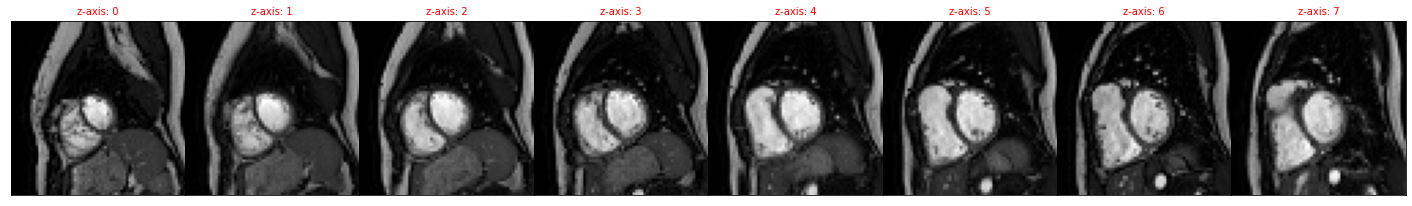

(5, 8, 64, 64, 1)


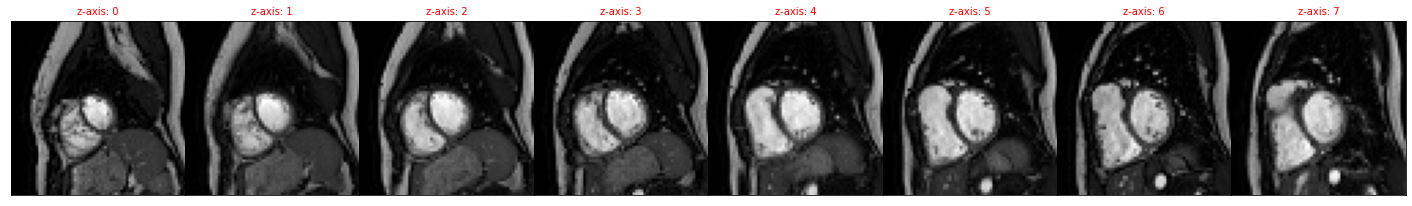

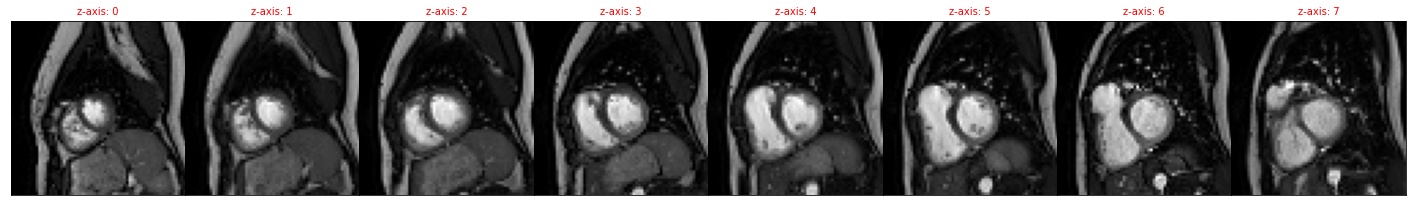

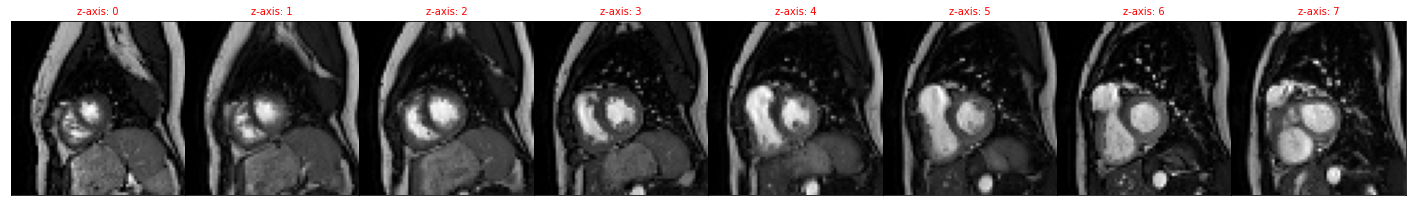

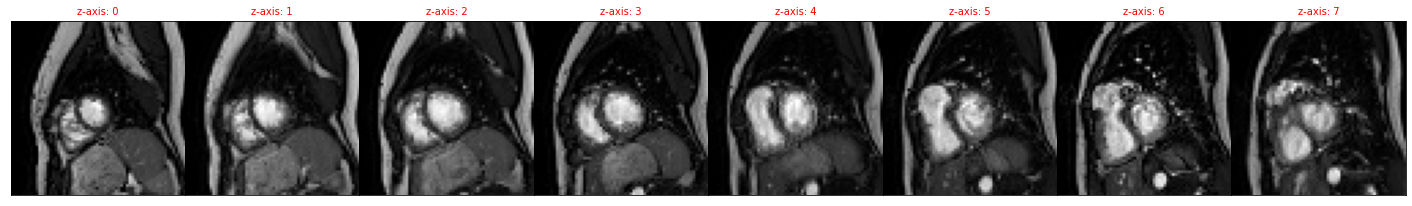

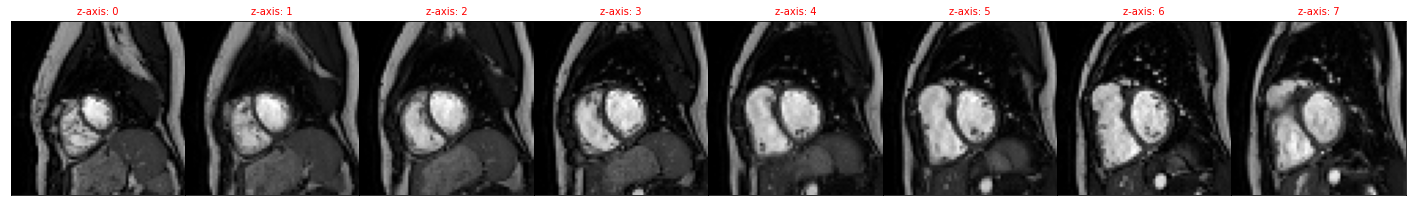

In [50]:
# slice of one patient
temp_in = inputs[0]
print('one patient input: {}'.format(temp_in.shape))
temp_idx = tf.cast(idxs[0], dtype = tf.int32)
print('one patient idx: {}'.format(temp_idx.shape))

# manually slice one timetep, as visual comparison
t1 = temp_idx[0]
print('t1: {}'.format(t1))
t1_in = temp_in[t1]
show_2D_or_3D(img=t1_in, interpol='bilinear',dpi=100,f_size=(5,5)); plt.show()

# slice ll 5 timeteps
t_all_in = tf.gather(temp_in, temp_idx)
print(t_all_in.shape)
_ = list(map(lambda x : show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), t_all_in ))

In [27]:
tf.squeeze(temp_idx)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 3,  8, 13, 16, 23])>

In [10]:
# get the true idx
temp = 
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

[[[1 1 1 1 1]
  [1 1 1 1 1]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 1 1 0]
  [0 1 1 1 0]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 ...

 [[1 1 1 1 0]
  [0 1 1 1 1]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 1 0 1]
  [1 1 1 0 0]
  [0 1 1 1 0]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 0 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


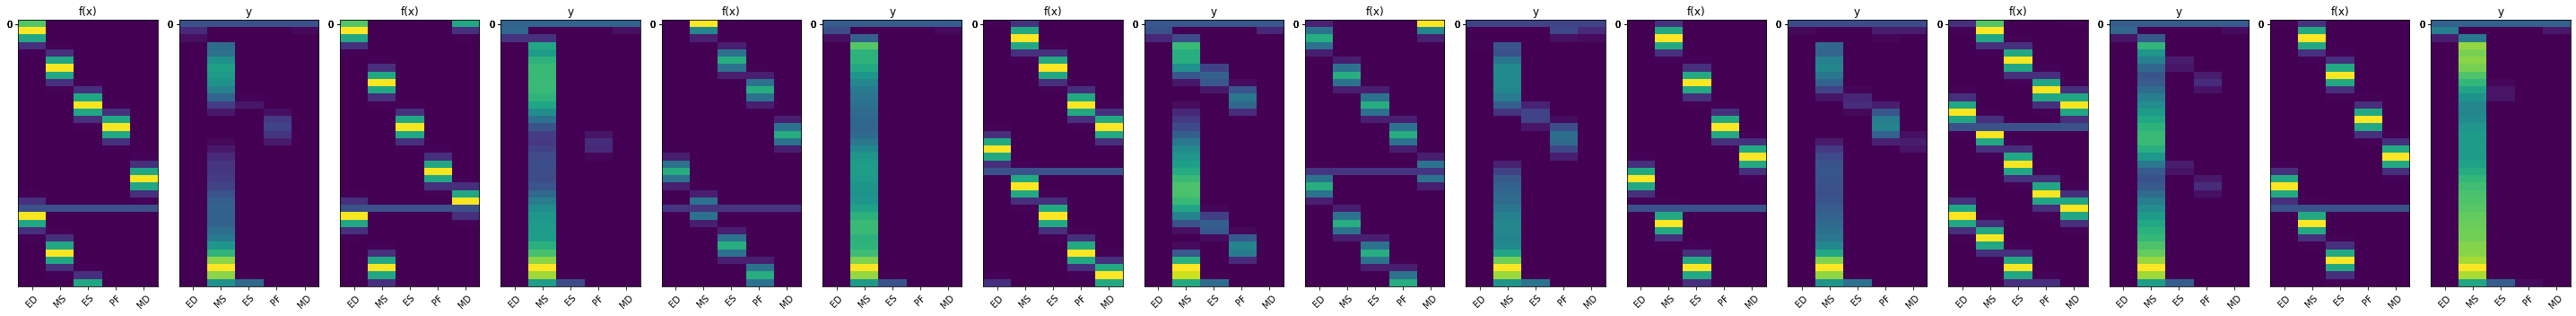

In [23]:
from src.visualization.Visualize import show_phases, show_phases_transpose
_ = show_phases(pred,outputs)

In [25]:
pred.shape

TensorShape([8, 2, 36, 5])

In [14]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
score_fn(outputs, pred).numpy()

24.776663

In [14]:
temp = outputs[:,0,...]
print(temp.shape)
print(temp.T.shape)
plt.imshow(temp.T[0])

NameError: name 'outputs' is not defined

In [15]:
# calculate the meandiff score for all batches
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

ModuleNotFoundError: No module named 'src.utils.Metrics'

In [18]:
tf.reduce_mean(scores).numpy()

6.75

# Generator tests

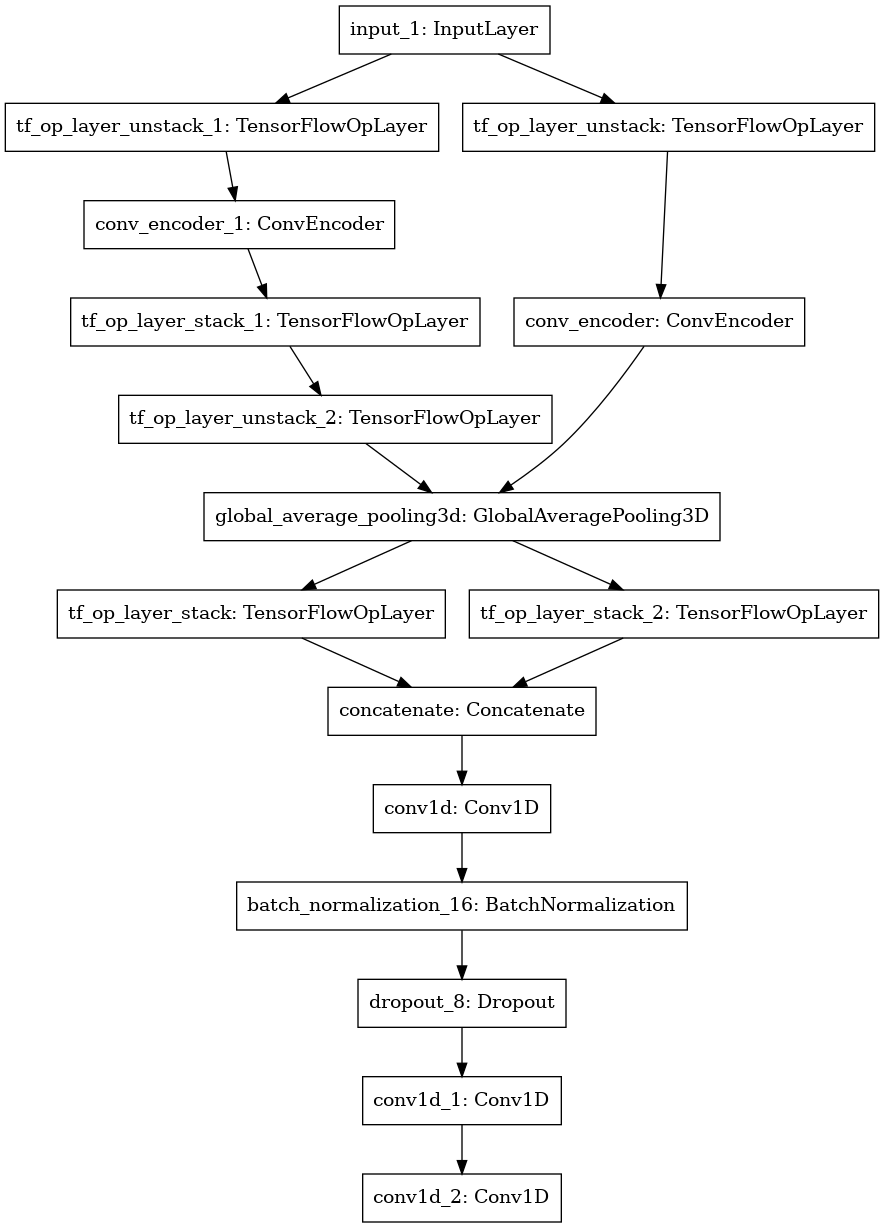

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)